In [117]:
import glob
import multiprocessing
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

def model_srcnn(model, img_path, s):
    file_dir, file_name = os.path.split(img_path)
    file_name, file_ext = os.path.splitext(file_name)
    img = Image.open(img_path).convert('YCbCr')

    _tmp = img.resize((int(img.size[0]/s), int(img.size[1]/s)), Image.Resampling.BICUBIC)
    img_lr = _tmp.resize((img.size[0], img.size[1]), Image.Resampling.BICUBIC)

    y, cb, cr = img_lr.split()

    img_to_tensor = transforms.ToTensor()
    input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0])

    out = model(input)
    out = out.cpu()
    # display(out)
    out_img_y = out[0].clone().detach().numpy()
    out_img_y *= 255.0
    out_img_y = out_img_y.clip(0, 255)
    # display(out_img_y)

    out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

    img_hr = Image.merge('YCbCr', [out_img_y, cb, cr]).convert('RGB')
    return img_hr


In [118]:
class Hook(object):
    def __init__(self):
        self.module_name = []
        self.features_in_hook = []
        self.features_out_hook = []


    def __call__(self,module, fea_in, fea_out):
        print("hooker working", self)
        self.module_name.append(module.__class__)
        self.features_in_hook.append(fea_in)
        self.features_out_hook.append(fea_out)
        return None

Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))


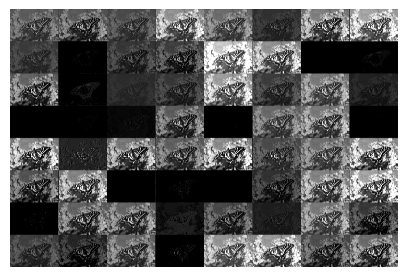

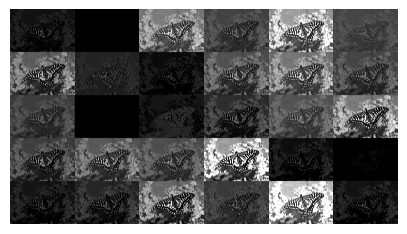

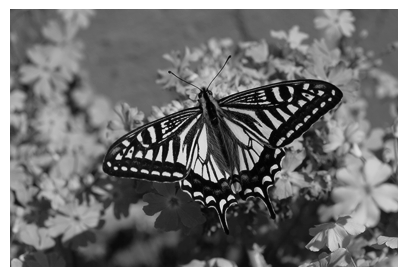

In [119]:
scale = 4
model_file = r'/root/autodl-tmp/DL/DLL/models/srcnn_x{}/model_199.pth'.format(scale)
model = torch.load(model_file).cpu()

visualisation = {}

def hook_fn(m, i, o):
  visualisation[m] = (i, o)

def get_all_layers(net):
  for name, layer in net._modules.items():
    #If it is a sequential, don't register a hook on it
    # but recursively register hook on all it's module children
    if isinstance(layer, torch.nn.Sequential):
      get_all_layers(layer)
    else:
      # it's a non sequential. Register a hook
      layer.register_forward_hook(hook_fn)

get_all_layers(model)

img = model_srcnn(model, "/root/autodl-tmp/DL/DATASET/DIV2K_valid_HR/0882.png", scale)
# display(img)


for layer, [feat_in_group, feat_out_group] in visualisation.items():
    print(layer)
    for feat_out_imgs in feat_out_group:
        # for feat_img in feat_imgs:
        feat_imgs = feat_out_imgs.clone().cpu().detach().numpy()
        feat_imgs *= 255.0
        feat_imgs = feat_imgs.clip(0, 255)
        
        cols = int(np.round(np.sqrt(feat_imgs.shape[0])))
        tiled_img = []
        lst_imgs = []
        for i in range(feat_imgs.shape[0]):
          lst_imgs.append(feat_imgs[i])
          if lst_imgs.__len__() >= cols:
            ppp = np.concatenate(lst_imgs, axis=1)
            tiled_img.append(ppp)
            lst_imgs = []
        m = np.concatenate(tiled_img, axis=0)

        plt.figure(figsize=(5, 5))
        plt.xticks([]), plt.yticks([])
        plt.axis('off')
        # plt.title(layer)
        plt.imshow(m, cmap='gray')
